# RNA-seqカウントデータの読み込み・前処理

In [12]:
pwd

'/Users/tanizawa/study/training_session/python_bioinfo_2018/2-1_and_2-2'

In [7]:
# pandasのインポート
import pandas as pd
import numpy as np

In [2]:
count_file = "input/counts.txt"
gene_id_product_file = "input/gene_id_product.tsv"

## カウントデータファイルの読み込み


__課題１ pd.read_tableまたはpd_read_csvを使って count_file を読み込む__  
```
df = pd.read_table(...
```

```
# Program:featureCounts v1.6.2; Command:"../tools/subread-1.6.2-Linux-x86_64/bin/featureCounts" "-p" "-T" "8" "-t" "exon" "-g" "gene_id" "-a" "../reference/s288c_e.gff" "-o" "../featurecount/counts.txt" "SRR453566.sorted.bam" "SRR453567.sorted.bam" "SRR453568.sorted.bam" "SRR453569.sorted.bam" "SRR453570.sorted.bam" "SRR453571.sorted.bam" 
Geneid  Chr     Start   End     Strand  Length  SRR453566.sorted.bam    SRR453567.sorted.bam    SRR453568.sorted.bam    SRR453569.sorted.bam    SRR453570.sorted.bam    SRR453571.sorted.bam
gene_0001       NC_001133.9     1807    2169    -       363     1       3       2       0       0       1
gene_0002       NC_001133.9     2480    2707    +       228     0       0       0       0       0       0
gene_0003       NC_001133.9     7235    9016    -       1782    0       0       0       0       0       0
gene_0004... 以下省略
```
1行目はfeatureCountsの実行条件が記載されているだけなので無視。二行目は列タイトルを表すヘッダー行。  
3行目以降からデータ行となっている。一番左の列が遺伝子idになっているのでこれをindexに用いる。a

pd.read_tableメソッドのskiprows、index_col、header オプションを指定して読み込む
```
skiprows : list-like or integer or callable, default None
    Line numbers to skip (0-indexed) or number of lines to skip (int)
    at the start of the file.

    If callable, the callable function will be evaluated against the row
    indices, returning True if the row should be skipped and False otherwise.
    An example of a valid callable argument would be ``lambda x: x in [0, 2]``.
    
index_col : int or sequence or False, default None
    Column to use as the row labels of the DataFrame. If a sequence is given, a
    MultiIndex is used. If you have a malformed file with delimiters at the end
    of each line, you might consider index_col=False to force pandas to _not_
    use the first column as the index (row names)
    
header : int or list of ints, default 'infer'
    Row number(s) to use as the column names, and the start of the data.
    Default behavior is as if set to 0 if no ``names`` passed, otherwise
    ``None``. Explicitly pass ``header=0`` to be able to replace existing
    names. The header can be a list of integers that specify row locations for
    a multi-index on the columns e.g. [0,1,3]. Intervening rows that are not
    specified will be skipped (e.g. 2 in this example is skipped). Note that
    this parameter ignores commented lines and empty lines if
    ``skip_blank_lines=True``, so header=0 denotes the first line of data
    rather than the first line of the file.
```

__読み込めたら、データ件数、統計値などの確認を行ってみる__

## 列名を変更する

__以後の解析のため、列名を変更しておく。  
下記２セルを実行する__

In [8]:
# 列名を変更するための対応表
names = {'SRR453566.sorted.bam': 'batch_1',
         'SRR453567.sorted.bam': 'batch_2',
         'SRR453568.sorted.bam': 'batch_3',
         'SRR453569.sorted.bam': 'chemostat_1',
         'SRR453570.sorted.bam': 'chemostat_2',
         'SRR453571.sorted.bam': 'chemostat_3'}

In [9]:
# rename_axisをaxis=1を適用して使い、列名を変更する
df = df.rename_axis(mapper=names, axis=1)

# rename_axisを使わなくても、既存の列を別名でコピーした後で元の列を削除、という方法でも可能
# df["batch_1"] = df['SRR453566.sorted.bam']
# del df['SRR453566.sorted.bam']

In [10]:
df.head()

,Chr,Start,End,Strand,Length,batch_1,batch_2,batch_3,chemostat_1,chemostat_2,chemostat_3
Geneid,,,,,,,,,,,
gene_0001,NC_001133.9,1807,2169,-,363,0,2,6,0,0,1
gene_0002,NC_001133.9,2480,2707,+,228,0,0,0,0,0,0
gene_0003,NC_001133.9,7235,9016,-,1782,0,0,0,0,0,0
gene_0004,NC_001133.9,11565,11951,-,387,0,0,0,0,0,0
gene_0005,NC_001133.9,12046,12426,+,381,2,8,10,6,7,18


## ミトコンドリア上の遺伝子を除く

__課題２ counts.txtにはミトコンドリア上の遺伝子も含まれるのでこれを除く。  
df.Chrの値が NC_001224.1 に一致するものがミトコンドリアに該当するので、boolean indexingを使って除く__

In [12]:
# 正しく処理ができればデータ件数は6394件になるはず
df.shape

(6394, 11)

## gene_idとproductの一覧ファイルを読み込む


__課題３　pd.read_tableを使ってgene_id_productを読み込む。  
一列目をindexとして用いること。ヘッダー行がないので、 names=["gene_id", "product"]オプションを指定して読み込むこと。  
データフレーム名は gene_product とすること  
```
gene_products = pd.read_table(.....)
```__

```
gene_0001	seripauperin PAU8
gene_0002	hypothetical protein
gene_0003	putative permease SEO1
gene_0004	hypothetical protein
gene_0005	hypothetical protein
gene_0006	Tda8p
gene_0007...
```
namesオプション
```
names : array-like, default None
    List of column names to use. If file contains no header row, then you
    should explicitly pass header=None. Duplicates in this list are not
    allowed unless mangle_dupe_cols=True, which is the default.
```



In [14]:
gene_products.head()

,product
gene_id,
gene_0001,seripauperin PAU8
gene_0002,hypothetical protein
gene_0003,putative permease SEO1
gene_0004,hypothetical protein
gene_0005,hypothetical protein


## 二つのデータフレームを連結

__課題４　gene_productsにdfを連結する。  
index列を使って接続するので join を使うのが良い。  
データフレーム名はdf_with_productとすること。__
```
df_with_product = gene_products.join(...
```


本来であれば rRNA　にマップされたリードは無視したいので除く必要がある。  
gene_products には mRNA のデータしか含まれていないので、rRNA などのデータはこの時点で除かれる。  


In [16]:
# mergeを使った場合
# pd.merge(gene_products, df, left_index=True, right_index=True) 

In [17]:
# concatを使った場合
# pd.concat([gene_products, df], axis=1, join="inner")

In [18]:
df_with_product.head()

,product,Chr,Start,End,Strand,Length,batch_1,batch_2,batch_3,chemostat_1,chemostat_2,chemostat_3
gene_id,,,,,,,,,,,,
gene_0001,seripauperin PAU8,NC_001133.9,1807,2169,-,363,0,2,6,0,0,1
gene_0002,hypothetical protein,NC_001133.9,2480,2707,+,228,0,0,0,0,0,0
gene_0003,putative permease SEO1,NC_001133.9,7235,9016,-,1782,0,0,0,0,0,0
gene_0004,hypothetical protein,NC_001133.9,11565,11951,-,387,0,0,0,0,0,0
gene_0005,hypothetical protein,NC_001133.9,12046,12426,+,381,2,8,10,6,7,18


##  カウントデータ部分のみを切り出し

In [19]:
df_count = df_with_product[["batch_1","batch_2","batch_3","chemostat_1","chemostat_2","chemostat_3"]]
# スライスで指定するなら　df_with_product.iloc[:, 6:12]

## ファイルの保存

In [20]:
df_with_product.to_csv("output/count_preprocessed.tsv", sep="\t")

In [21]:
# raw カウントのデータを保存する
df_count.to_csv("output/count_raw.tsv", sep="\t")

In [23]:
%%bash
# シェルコマンド head を使って確認してみます。
head output/count_raw.tsv

gene_id	batch_1	batch_2	batch_3	chemostat_1	chemostat_2	chemostat_3
gene_0001	0	2	6	0	0	1
gene_0002	0	0	0	0	0	0
gene_0003	0	0	0	0	0	0
gene_0004	0	0	0	0	0	0
gene_0005	2	8	10	6	7	18
gene_0006	0	0	0	0	0	0
gene_0007	0	0	0	0	0	0
gene_0008	0	0	0	0	0	0
gene_0009	32	37	33	43	63	84


# リード数で正規化 (100万リードあたりのカウント数に揃える, RPM/FPM)
RPM = reads per million


In [24]:
#いったん別のデータフレームとしてコピーしておく
df_tmp = df_count.copy()

__課題５　カウント数を、列ごとのリード数の合計で割ったあと、100万をかけてリード数で正規化を行う__

In [29]:
# ただしく処理できていれば、下記のようになるはず。
# リード数の合計が100万に揃っていることを確認。
df_tmp.sum()

batch_1        1000000.0
batch_2        1000000.0
batch_3        1000000.0
chemostat_1    1000000.0
chemostat_2    1000000.0
chemostat_3    1000000.0
dtype: float64

__上記の処理を関数化しておく。__


In [ ]:
def normalize_per_million_reads(df):
    ....
    ....

In [31]:
df_count_fpm = normalize_per_million_reads(df_count)

In [32]:
df_count_fpm.sum()

batch_1        1000000.0
batch_2        1000000.0
batch_3        1000000.0
chemostat_1    1000000.0
chemostat_2    1000000.0
chemostat_3    1000000.0
dtype: float64

In [33]:
# FPM正規化を行った結果を保存
df_count_fpm.to_csv("output/count_fpm.tsv", sep="\t")

# 遺伝子長による正規化 (RPKM/FPKM)
上で求めたFPMをさらに遺伝子長で割ってFPKMを求める。  
FPKM = fragments per kilobase of exon per million reads mapped
single-endの場合、RPKM = reads per kilobase of exon per million reads mapped と呼ばれるが、 FPKM/RPKMはほぼ同じ意味で用いられる

In [34]:
# テスト用にデータフレームをコピーしておく
df_tmp = df_count_fpm.copy()

In [35]:
gene_length = df_with_product["Length"]

In [36]:
# ↓はうまくいきません。（縦方向にブロードキャストされてしまうため）
# df_tmp / gene_length

In [37]:
# 一列ずつ計算することは可能
# df_tmp["batch_1"] / gene_length * 10**3

__課題６　次のいずれかの方法でFPKMを求める(fpmの値を遺伝子長で割って、1000をかければ良い）__

## for ループを使う方法

データフレームをforループで回すと、列名が取得できるのでそれを利用する。

## データフレームを転置してから計算する方法　（おすすめ）

## applyを使い各列に関数を適用する

In [41]:
# はじめに列を入力とし、各要素を遺伝子長でわる処理を行う関数を定義する
def divide_by_length(S):
    ...

## データフレームメソッドのdivideを使用する方法

In [9]:
# データフレームメソッドのdivideを使用する方法もあります。
df_tmp = df_count_fpm.copy()
df_tmp = df_tmp.divide?  # ←ヘルプを参照してください


In [44]:
# 関数化しておきます。
def normalize_per_kilobase(df, gene_length):
    ...

In [45]:
df_count_fpkm = normalize_per_kilobase(df_count_fpm, gene_length)

In [46]:
df_count_fpkm.head()

,batch_1,batch_2,batch_3,chemostat_1,chemostat_2,chemostat_3
gene_id,,,,,,
gene_0001,0.000000,0.881103,3.653609,0.000000,0.00000,0.561926
gene_0002,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
gene_0003,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
gene_0004,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
gene_0005,1.149909,3.357905,5.801662,5.123019,4.74806,9.636806


In [60]:
# 保存する
df_count_fpkm.to_csv("output/count_fpkm.tsv", sep="\t")

# TPM 正規化
TPM = transcripts per kilobase million  
TPM の説明については以下のページが詳しい https://bi.biopapyrus.jp/  
FPKM/RPKM のときとは逆に、長さ1,000bpあたりのリード数を求めてから、総リード数を100万に揃えれば良い。

In [61]:
df_tmp = df_count.copy()

In [62]:
df_tmp = normalize_per_kilobase(df_tmp, gene_length)
df_tmp = normalize_per_million_reads(df_tmp)


In [63]:
df_tmp.head()

,batch_1,batch_2,batch_3,chemostat_1,chemostat_2,chemostat_3
gene_id,,,,,,
gene_0001,0.00000,0.734587,3.129839,0.000000,0.000000,0.504810
gene_0002,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
gene_0003,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
gene_0004,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
gene_0005,0.94849,2.799529,4.969954,4.689762,4.372026,8.657291


In [64]:
# RPKM/FPKMと違い、合計が100万となっています。
df_tmp.sum()

batch_1        1000000.0
batch_2        1000000.0
batch_3        1000000.0
chemostat_1    1000000.0
chemostat_2    1000000.0
chemostat_3    1000000.0
dtype: float64

In [65]:
# 関数化します
def normalize_tpm(df, gene_length):
    df_tmp = df.copy()
    df_tmp = normalize_per_kilobase(df_tmp, gene_length)
    df_tmp = normalize_per_million_reads(df_tmp)
    return df_tmp

In [66]:
df_count_tpm = normalize_tpm(df_count, gene_length)

In [67]:
df_count_tpm.sum() #  確認

batch_1        1000000.0
batch_2        1000000.0
batch_3        1000000.0
chemostat_1    1000000.0
chemostat_2    1000000.0
chemostat_3    1000000.0
dtype: float64

In [68]:
# 保存
df_count_tpm.to_csv("output/count_tpm.tsv", sep="\t")

* 参考）numpyを使った高速バージョンとの比較

In [69]:
%%timeit
# pandasで実装したもの
normalize_tpm(df_count, gene_length)

100 loops, best of 3: 1.85 ms per loop


In [72]:
# valuesによりnumpy.ndarrayとして数値データを抽出
counts = df_count.values
length =gene_length.values

In [73]:
%%timeit
# numpyで計算

# 長さで正規化。行方向へbroadcastを行うため、reshapeしておく必要がある
counts_tmp = counts / length.reshape(-1, 1) * 1000
# カウント数の各列の合計を求めておく
sum_count = counts_tmp.sum(axis=0)
# 100万カウントに揃える
tpm = counts_tmp / sum_count * 1000000

1000 loops, best of 3: 310 µs per loop


# 発現変動の大きかった遺伝子を抽出する

In [74]:
# batch cultureの平均を求める
df_count_fpkm["batch"] = (df_count_fpkm["batch_1"] + df_count_fpkm["batch_2"] + df_count_fpkm["batch_3"]) / 3


In [75]:
# chemostatの平均を求める
df_count_fpkm["chemostat"] = (df_count_fpkm["chemostat_1"] + df_count_fpkm["chemostat_2"] + df_count_fpkm["chemostat_3"]) / 3

In [76]:
# 発現変動をlog2 fold として求める
# 0 での除算を防ぐため、分母に微小な値を加えている
df_count_fpkm["log2fold"] = df_count_fpkm["chemostat"] / (df_count_fpkm["batch"] + 10**-6)
df_count_fpkm["log2fold"] = df_count_fpkm["log2fold"].apply(np.log2)

In [77]:
df_count_fpkm.head()

,batch_1,batch_2,batch_3,chemostat_1,chemostat_2,chemostat_3,batch,chemostat,log2fold
gene_id,,,,,,,,,
gene_0001,0.000000,0.881103,3.653609,0.000000,0.00000,0.561926,1.511571,0.187309,-3.012560
gene_0002,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-inf
gene_0003,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-inf
gene_0004,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-inf
gene_0005,1.149909,3.357905,5.801662,5.123019,4.74806,9.636806,3.436492,6.502628,0.920086


In [78]:
# 必要部分のみ抜き出し、productと結合
diff_ex = df_count_fpkm[["batch", "chemostat", "log2fold"]]
diff_ex = diff_ex.join(gene_products)

In [79]:
diff_ex.head()

,batch,chemostat,log2fold,product
gene_id,,,,
gene_0001,1.511571,0.187309,-3.012560,seripauperin PAU8
gene_0002,0.000000,0.000000,-inf,hypothetical protein
gene_0003,0.000000,0.000000,-inf,putative permease SEO1
gene_0004,0.000000,0.000000,-inf,hypothetical protein
gene_0005,3.436492,6.502628,0.920086,hypothetical protein


In [11]:
# カウント数が0であるデータを除いておく
#diff_ex = diff_ex[diff_ex["batch"] > 0]
#diff_ex = diff_ex[diff_ex["chemostat"] > 0]

In [10]:
#diff_ex

__課題7 log2foldの列を降順に並び替える（diff_ex.sort_valuesを使う)__

In [83]:
diff_ex.head()

,batch,chemostat,log2fold,product
gene_id,,,,
gene_2989,0.511745,1610.887557,11.620140,Rgi2p
gene_4740,3.717076,5574.454736,10.550447,Sip18p
gene_4667,5.975449,5113.855146,9.741148,Spg4p
gene_5965,8.615621,5815.573818,9.398751,Gre1p
gene_4237,1.158934,776.350184,9.387764,hypothetical protein


In [84]:
diff_ex.tail()

,batch,chemostat,log2fold,product
gene_id,,,,
gene_0314,12.593317,1.214752,-3.373925,ADP/ATP carrier protein AAC3
gene_2429,2.481020,0.202360,-3.615936,hypothetical protein
gene_2725,938.239733,73.367263,-3.676748,hexose transporter HXT4
gene_5487,92.881590,6.848675,-3.761496,hypothetical protein
gene_1320,969.132836,50.512030,-4.261995,hexose transporter HXT3


以下はおまけ。TPM正規化したデータをクラスタリングしてみます

In [90]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

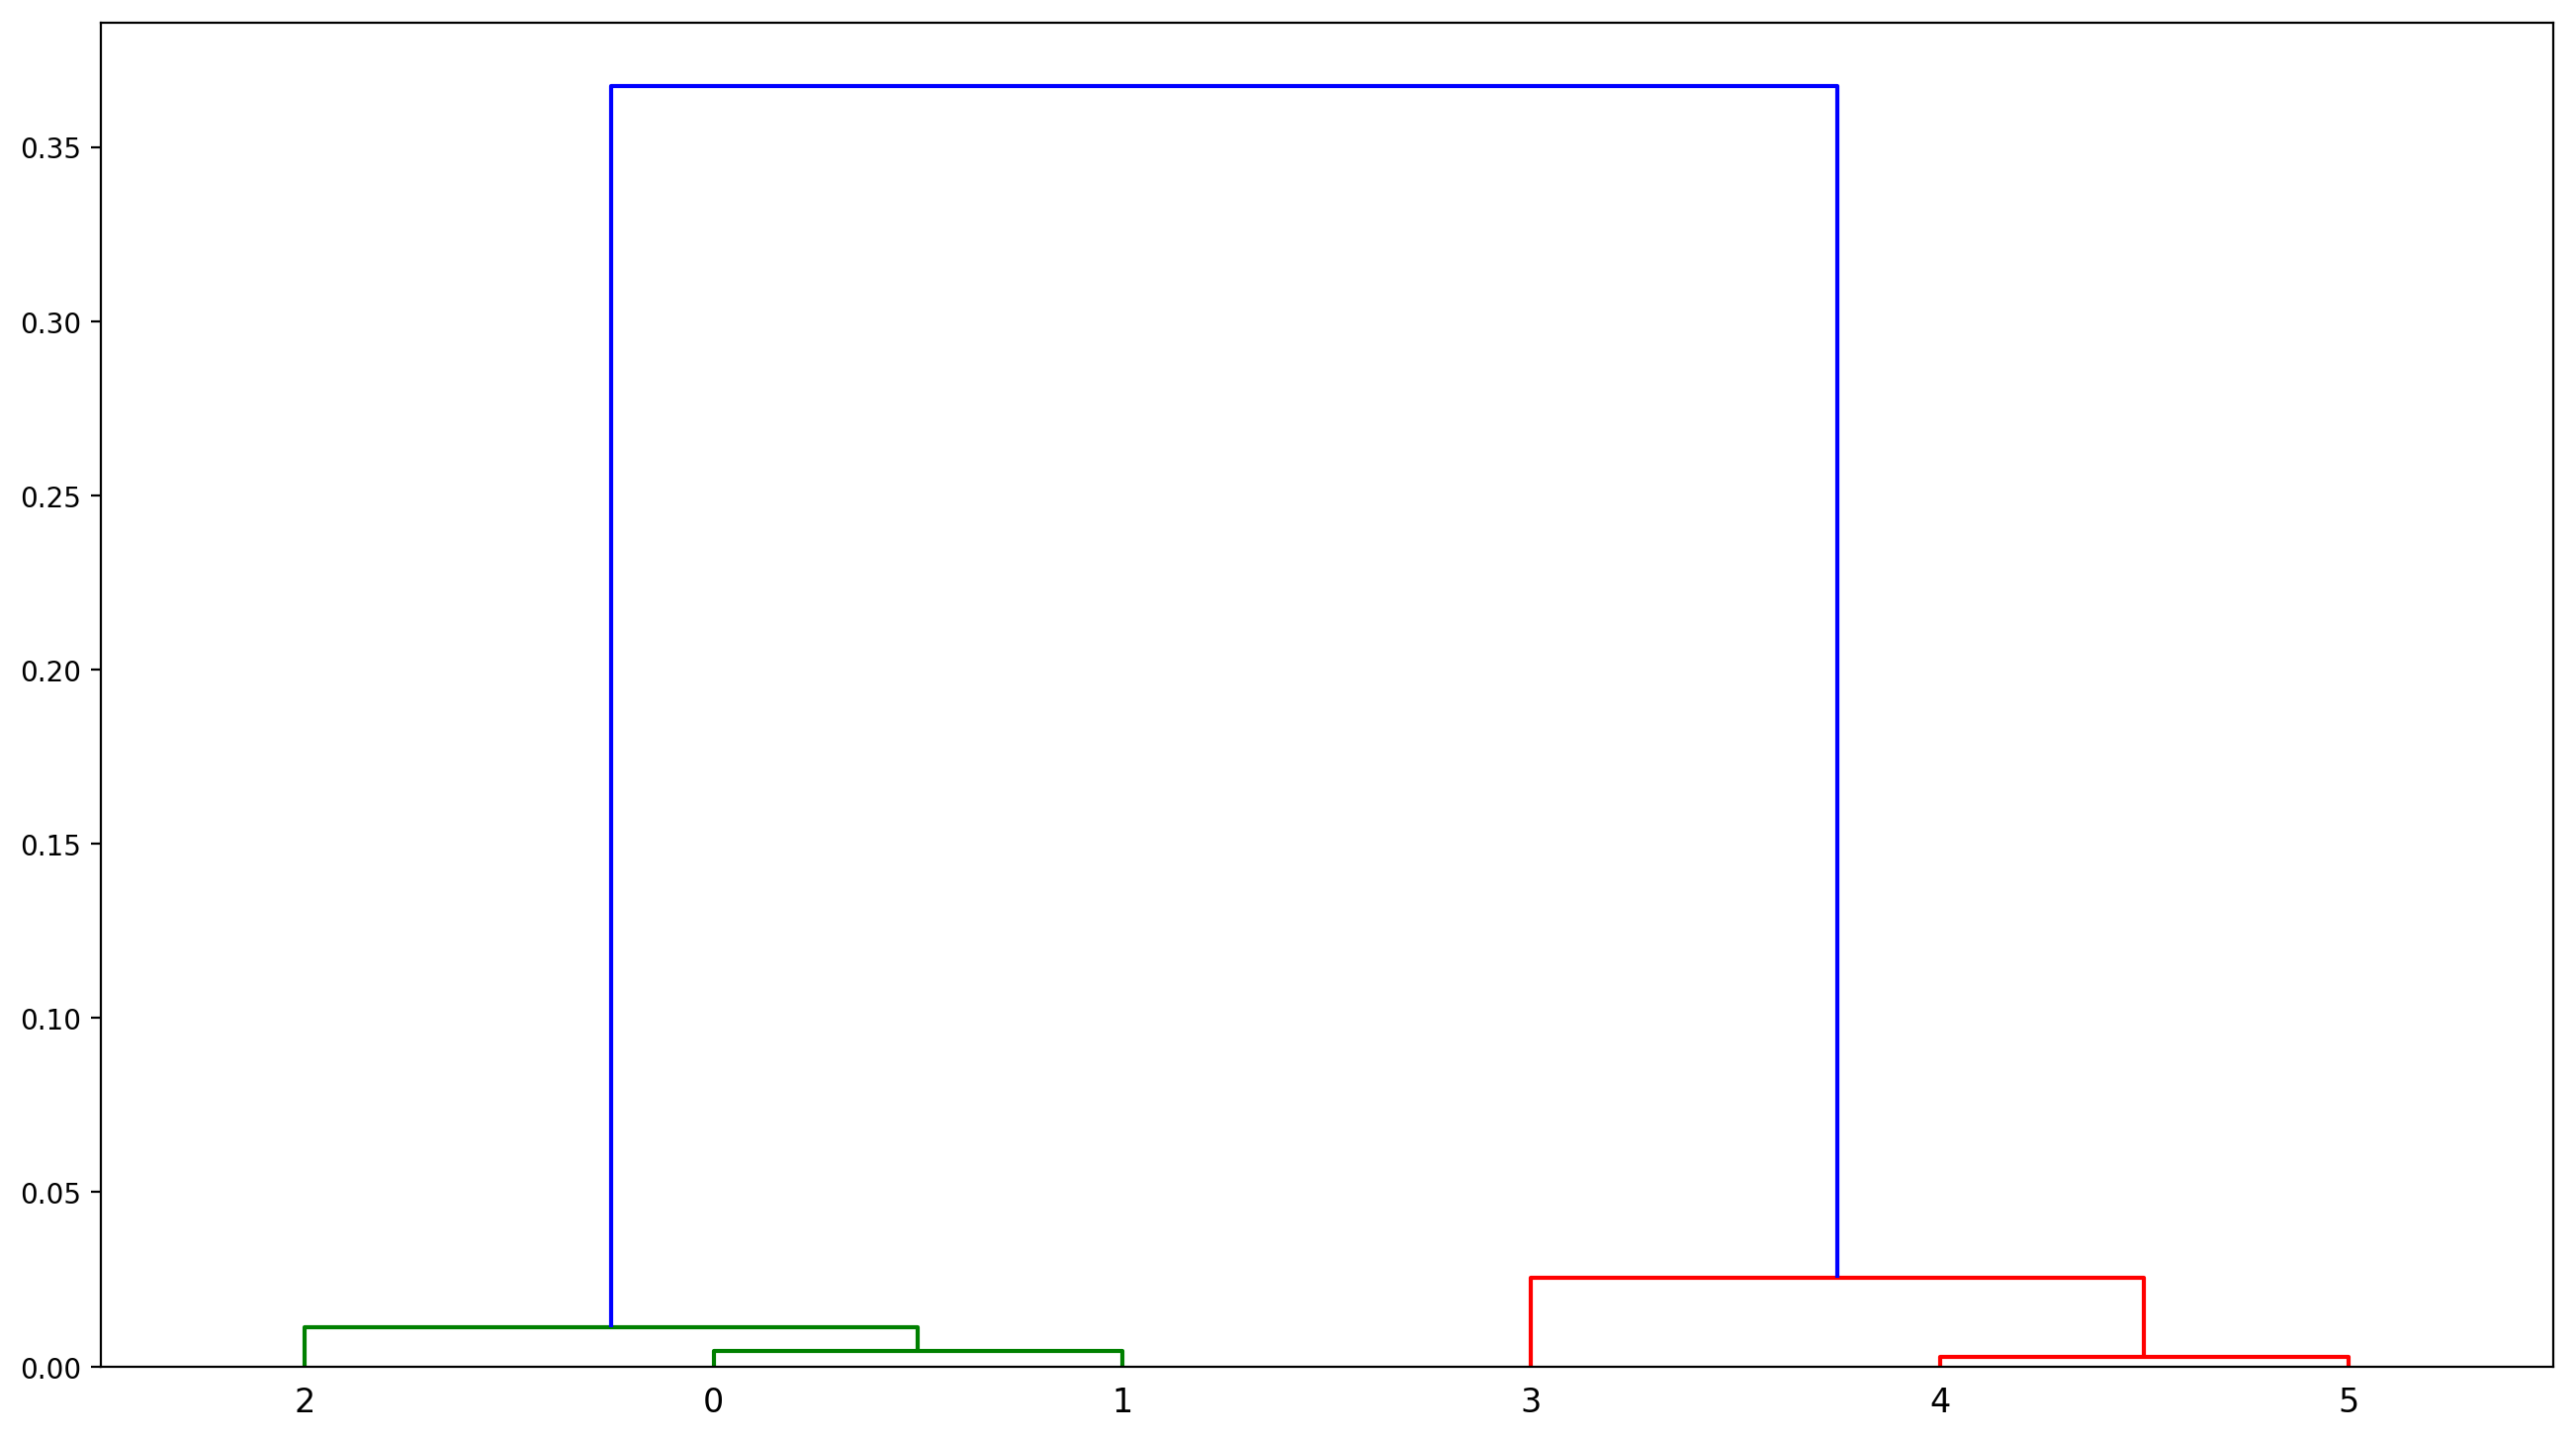

In [91]:
tpm_t = df_count_tpm.T
linkage_result = linkage(tpm_t, method='average', metric='correlation')
plt.figure(num=None, figsize=(16, 9), dpi=200, facecolor='w', edgecolor='k')
dendrogram(linkage_result)
plt.show()